In [3]:
%matplotlib inline


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
from haversine import haversine

import folium as flm
from folium.plugins import HeatMap

In [5]:
# %%time

train_path  = 'data/train.csv'


traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

df = pd.read_csv(train_path, usecols=cols, dtype=traintypes)

In [14]:
df = df.sample(n=5000000,random_state=5,replace=True)

In [15]:
#%%time

#df.to_feather('nyc_taxi_data_raw.feather')

In [16]:
# df = pd.read_feather('data/nyc_taxi_data_raw.feather')



In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000000 entries, 13929315 to 6466183
Data columns (total 13 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
day_of_week          int64
month                int64
month_name           object
hour                 int64
dayname              object
times                object
dtypes: datetime64[ns](1), float32(5), int64(3), object(3), uint8(1)
memory usage: 405.3+ MB


In [22]:
df.drop(df[df.fare_amount < 0].index, inplace=True)

In [23]:
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'],infer_datetime_format=True)


In [24]:
df["day_of_week"] = df.pickup_datetime.dt.dayofweek
df["month"] = df.pickup_datetime.dt.month
df["month_name"] = df.pickup_datetime.dt.month_name()
df["hour"] = df.pickup_datetime.dt.hour
df["dayname"] = df.pickup_datetime.dt.day_name()


In [25]:
df['times'] = ['day' if (x >= 5 and x <= 11) else 'afternoon' if (x > 11 and x <=17) else 'evening' if (x > 17 and x < 22) else 'night' if (x >= 22) else 'night' if (x >= 0 and x < 5) else 'error' for x in df['hour']] 

In [26]:
df.reset_index(drop=True, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 13 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
day_of_week          int64
month                int64
month_name           object
hour                 int64
dayname              object
times                object
dtypes: datetime64[ns](1), float32(5), int64(3), object(3), uint8(1)
memory usage: 367.2+ MB


> ### How is the fare price distributed?
* We will use this information to infer about types of trips preferred by riders.

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

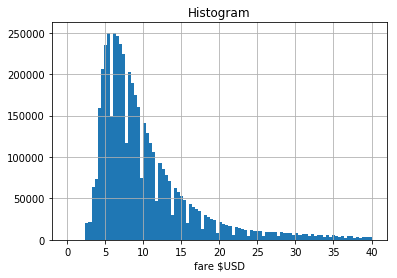

In [28]:
df.fare_amount.hist(bins=100,range=(df.fare_amount.min(),40))
plt.xlabel('fare $USD')
plt.title('Histogram');
plt.hist

### How does the the number of trips taken differ by month?
* We will use this information infer about seasonality in the data

Text(0.5, 1.0, 'Number of trips by month')

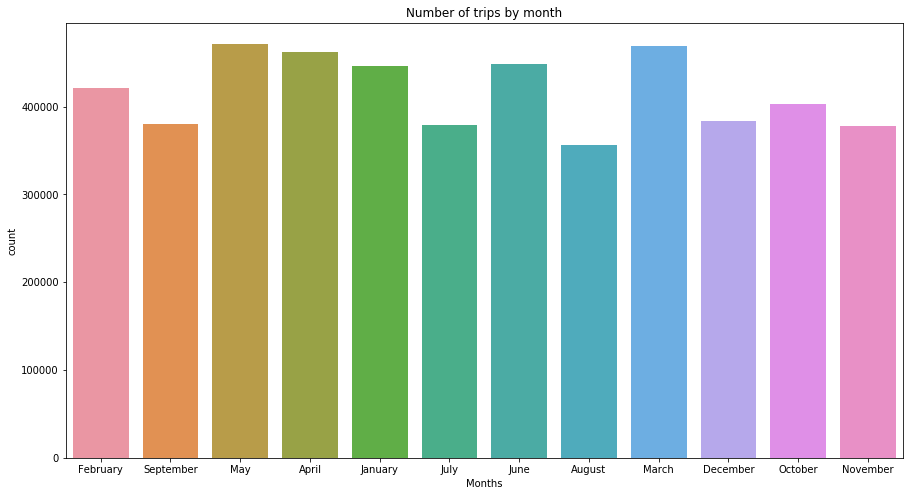

In [29]:
plt.figure(figsize=(15,8))
sns.countplot(x='month_name',data=df)
plt.xlabel('Months')
plt.title('Number of trips by month')

### How does the the number of trips taken differ by day of the week?
* We will use this information to see the day of the week with least number of rides

Text(0.5, 1.0, 'Number of trips by day of week')

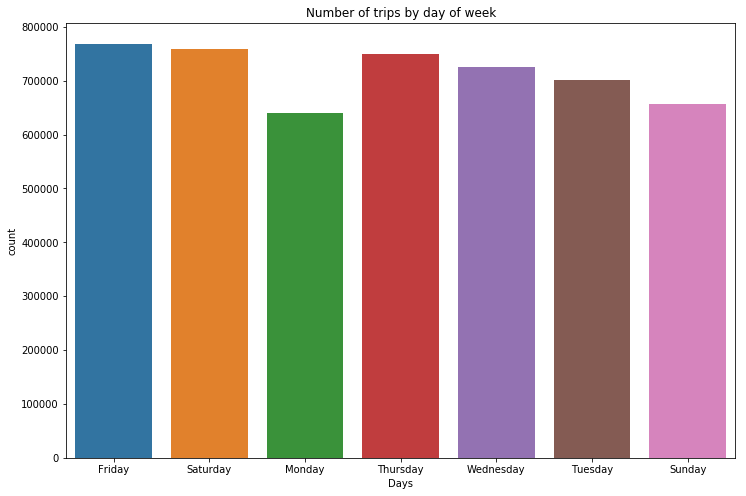

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x='dayname',data=df)
plt.xlabel('Days')
plt.title('Number of trips by day of week')

### How does the the number of trips taken differ by hour?


Text(0.5, 1.0, 'Number of trips by hour')

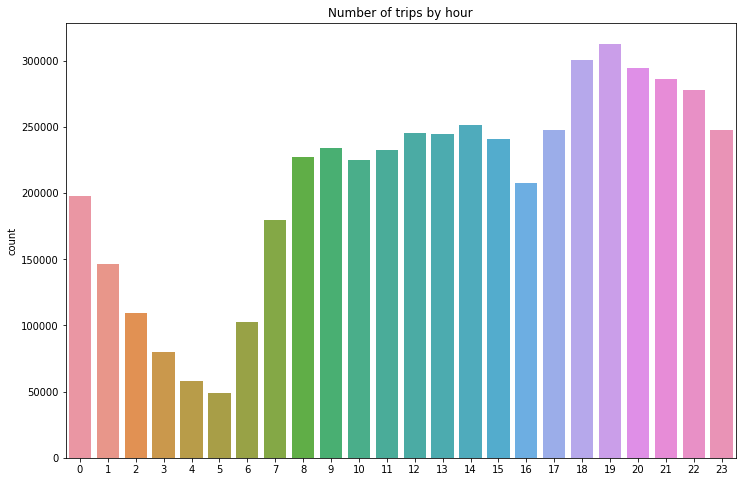

In [31]:
plt.figure(figsize=(12,8))
sns.countplot(x='hour',data=df)
plt.xlabel('')
plt.title('Number of trips by hour')

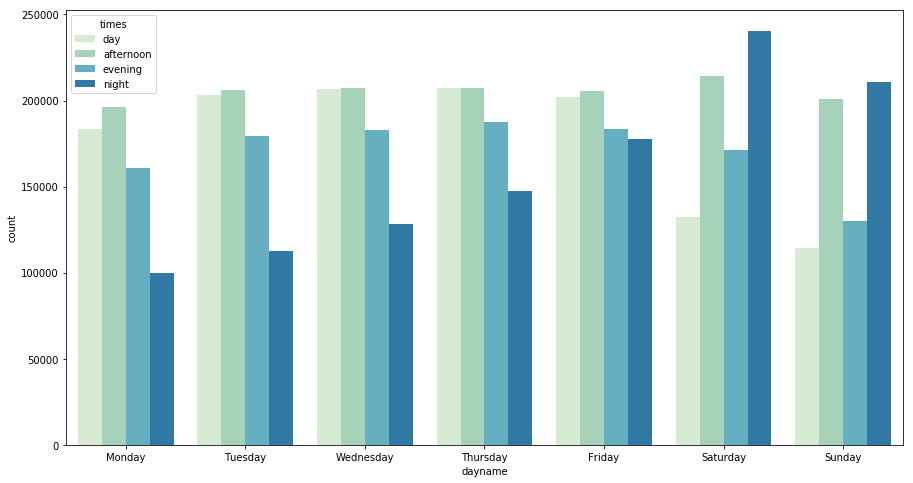

In [32]:
plt.figure(figsize=(15,8))

sns.countplot(x="dayname", hue="times", hue_order=["day","afternoon","evening","night"], palette  = "GnBu", data=df, order= ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday' , 'Sunday'])

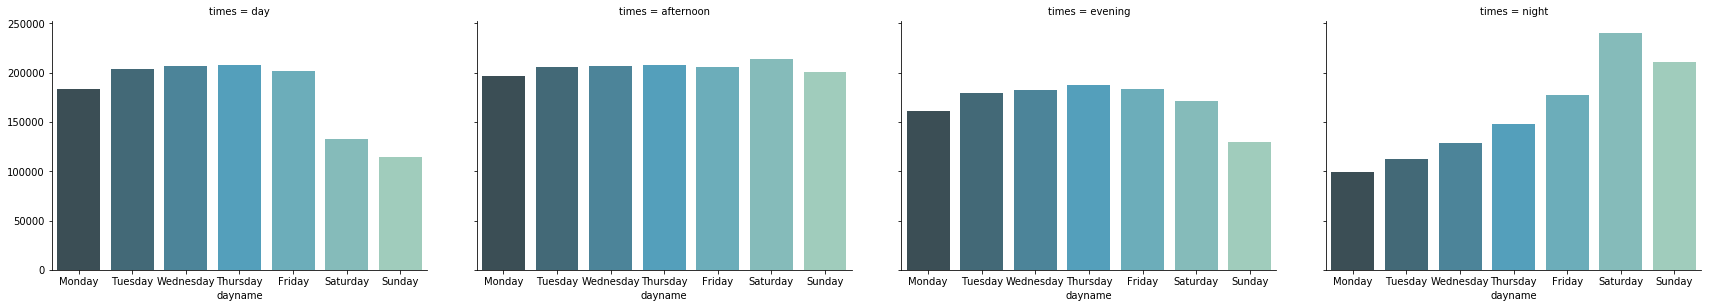

In [33]:
g=sns.FacetGrid(data=df,col='times',col_order=["day","afternoon","evening","night"])
g.map(sns.countplot,"dayname",order= ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday' , 'Sunday'],palette  = "GnBu_d",)
plt.gcf().set_size_inches(25, 5)

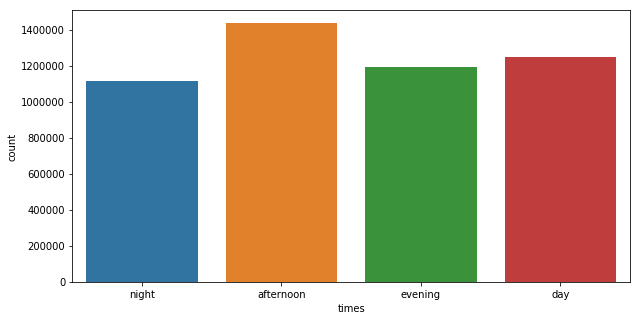

In [34]:
plt.figure(figsize=(10,5))

sns.countplot(x="times", data=df)

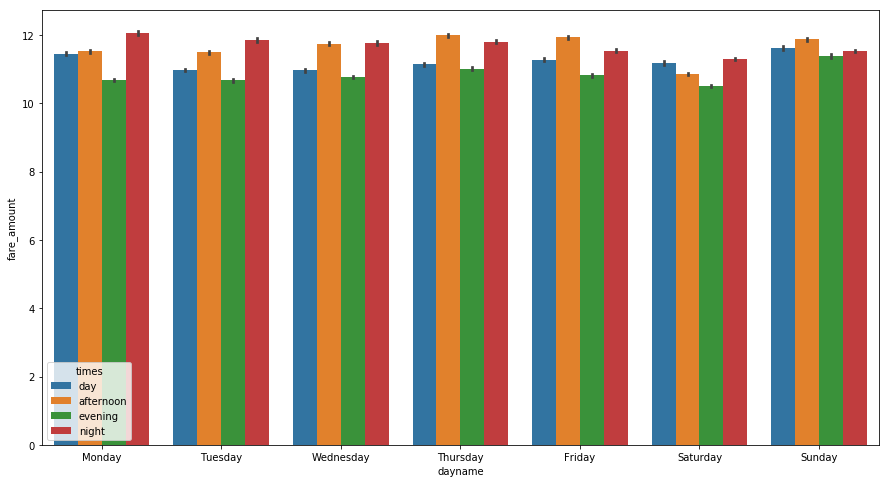

In [35]:
plt.figure(figsize=(15,8))

sns.barplot(x="dayname", hue="times",hue_order=["day","afternoon","evening","night"],y='fare_amount', data=df, order= ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday' , 'Sunday'])

In [36]:
print(df.groupby("times", as_index=True).fare_amount.mean())
print(df.groupby("times", as_index=True).fare_amount.median())

times
afternoon    11.628797
day          11.205697
evening      10.822056
night        11.630213
Name: fare_amount, dtype: float32
times
afternoon    8.5
day          8.1
evening      8.5
night        8.9
Name: fare_amount, dtype: float32


In [37]:
def calc_distance(df):
    pickups = (df['pickup_latitude'], df['pickup_longitude'])
    drops = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickups, drops)

In [38]:
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

/Users/mac/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mac/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


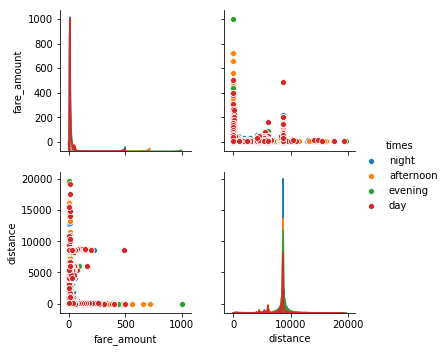

In [39]:
sns.pairplot(df,vars =[ 'fare_amount','distance'],hue='times')